In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(writexl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [2]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
beeswarm_results %>% head

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,3.786202,13.32846,28.65605,1.203665e-05,0.002250854,127,0.002451558,pos,Agrp,1,⋯,98.9882688,1.691103e-10,1.756868e-09,1.521349e-09,pos,1,89,neuron,3.216700,-13.25480
2,2.942268,13.13703,22.75446,5.730611e-05,0.003109848,18,0.003257913,pos,Agrp,1,⋯,18.4248083,2.056099e-04,5.340146e-04,4.726740e-04,pos,1,85,neuron,3.556380,-13.47460
3,3.762935,13.18959,23.36177,4.837156e-05,0.003109848,19,0.003257913,pos,Agrp,1,⋯,74.0789103,3.367667e-09,1.880265e-08,1.715807e-08,pos,1,80,neuron,3.986626,-12.99642
4,3.207390,13.03162,21.31327,8.646514e-05,0.003109848,41,0.003257913,pos,Agrp,1,⋯,12.4463870,1.529748e-03,2.466059e-03,2.251006e-03,pos,1,79,neuron,3.500047,-14.23880
5,2.281578,12.96570,21.49272,8.208911e-05,0.003109848,90,0.003257913,pos,Agrp,1,⋯,0.9013692,3.508883e-01,3.645340e-01,3.606322e-01,none,1,80,neuron,3.647344,-14.31736
6,4.542154,13.16189,22.97615,9.978122e-05,0.003109848,144,0.003257913,pos,Agrp,1,⋯,97.0751771,2.718156e-09,1.588422e-08,1.451895e-08,pos,1,76,neuron,2.933367,-13.35223


In [3]:
beeswarm_results %>% head %>% print

     logFC   logCPM        F       PValue         FDR Nhood  SpatialFDR
1 3.786202 13.32846 28.65605 1.203665e-05 0.002250854   127 0.002451558
2 2.942268 13.13703 22.75446 5.730611e-05 0.003109848    18 0.003257913
3 3.762935 13.18959 23.36177 4.837156e-05 0.003109848    19 0.003257913
4 3.207390 13.03162 21.31327 8.646514e-05 0.003109848    41 0.003257913
5 2.281578 12.96570 21.49272 8.208911e-05 0.003109848    90 0.003257913
6 4.542154 13.16189 22.97615 9.978122e-05 0.003109848   144 0.003257913
  polarity labels labels_fraction                      comparison restored
1      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
2      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
3      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
4      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5     TRUE
5      pos   Agrp               1 Day5.obob5v5__v__Day5.obobBL6d5    FALSE
6      pos   Agrp               1 Day5.obob5v5

In [4]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, fgf1_grouping) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(fgf1_grouping != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  mutate(not_none_pct = not_none_count/total_count) %>%
  mutate(none_count = total_count-not_none_count) %>%
#   arrange(desc(not_none_count), desc(total_count), labels) %>%
#   arrange(desc(not_none_pct), desc(not_none_count), labels) %>%
  arrange(desc(not_none_pct), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))

#save the level order for this
saved_levels = final_summary %>% pull(labels) %>% levels

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(fgf1_grouping = factor(fgf1_grouping, levels = c("pos", "none", "neg")))


# Assume final_summary_percent is already loaded
# Create a new variable to categorize counts into 'none' and 'DA'
final_summary_percent <- final_summary_percent %>%
  mutate(category = case_when(
    fgf1_grouping == "none" ~ "none",
    fgf1_grouping != 'none' ~ "DA")) %>%
  mutate(category = factor(category, levels = c('none', 'DA')))


decimal_to_percent_text <- function(decimal) {
  # Convert decimal to percentage
  percentage <- round(decimal * 100)
  percentage <- paste(percentage, "%", sep = "")
    
  # Check if the percentage is less than 1
  if (percentage == "0%") {
    percentage = "<1%"
  }
  percentage
}
final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels)) %>%
    rowwise %>%
    mutate(text_percent = decimal_to_percent_text(percent)) %>%
    ungroup

In [5]:
final_summary_percent

class,labels,fgf1_grouping,count,not_none_count,total_count,not_none_pct,none_count,percent,category,text_percent
<chr>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<fct>,<chr>
other,OPC,neg,31,58,97,0.59793814,39,0.31958763,DA,32%
other,OPC,none,39,58,97,0.59793814,39,0.40206186,none,40%
other,OPC,pos,27,58,97,0.59793814,39,0.27835052,DA,28%
neuron,Htr3b,neg,35,77,142,0.54225352,65,0.24647887,DA,25%
neuron,Htr3b,none,65,77,142,0.54225352,65,0.45774648,none,46%
neuron,Htr3b,pos,42,77,142,0.54225352,65,0.29577465,DA,30%
other,Astrocytes,neg,110,190,441,0.43083900,251,0.24943311,DA,25%
other,Astrocytes,none,251,190,441,0.43083900,251,0.56916100,none,57%
other,Astrocytes,pos,80,190,441,0.43083900,251,0.18140590,DA,18%


In [6]:
final_summary_percent %>% filter(labels == 'Pomc__Glipr1')

class,labels,fgf1_grouping,count,not_none_count,total_count,not_none_pct,none_count,percent,category,text_percent
<chr>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<fct>,<chr>
neuron,Pomc__Glipr1,neg,3,4,80,0.05,76,0.0375,DA,4%
neuron,Pomc__Glipr1,none,76,4,80,0.05,76,0.9500,none,95%
neuron,Pomc__Glipr1,pos,1,4,80,0.05,76,0.0125,DA,1%


In [7]:
final_summary_percent %>% filter(labels == 'Pou6f2__Prkcq__Whrn')

class,labels,fgf1_grouping,count,not_none_count,total_count,not_none_pct,none_count,percent,category,text_percent
<chr>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<fct>,<chr>
neuron,Pou6f2__Prkcq__Whrn,none,69,4,73,0.05479452,69,0.94520548,none,95%
neuron,Pou6f2__Prkcq__Whrn,pos,4,4,73,0.05479452,69,0.05479452,DA,5%


In [8]:
saved_levels

[1] "OPC"                 "Htr3b"               "Astrocytes"         
 [4] "Trh__Lef1"           "Ependymal_cells"     "Agrp"               
 [7] "Oligodendrocytes"    "Ghrh"                "Tbx19__Pirt"        
[10] "Sst__Pthlh"          "Tanycytes"           "Pou6f2__Prkcq__Whrn"
[13] "Pomc__Glipr1"        "Kiss1__Tac2"         "Sst__Unc13c"        
[16] "Ppp1r17__Tafa4"      "Th__Slc6a3"          "Irx5__Lmx1a"        
[19] "Arx__Nr5a2"          "Dlk1"                "Endothelial_cells"  
[22] "Esr1"                "Fez1"                "Gpr50__Tac2"        
[25] "Hdc"                 "Lepr15"              "Lepr67"             
[28] "Lepr89"              "Lpar1_oligo"         "Met__Pappa2"        
[31] "Met__Prlh"           "Microglia"           "Nfib_1"             
[34] "Nfib_2"              "Nfib_3"              "Nfix__Nfib"         
[37] "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"    "Npsr1__Epha3"       
[40] "Pomc__Anxa2"         "Pomc__Ttr"           "Ppp1r17"            
[43] "Ppp1r17__Ltbp1"      "Reln__Lef1"          "Sim1"               
[46] "Slc17a6__Trhr"       "Sst__Nts"            "Th__Nfib"           
[49] "Tmem215__Dach2"      "Tmem215__Greb1"      "Trh__Cxcl12"

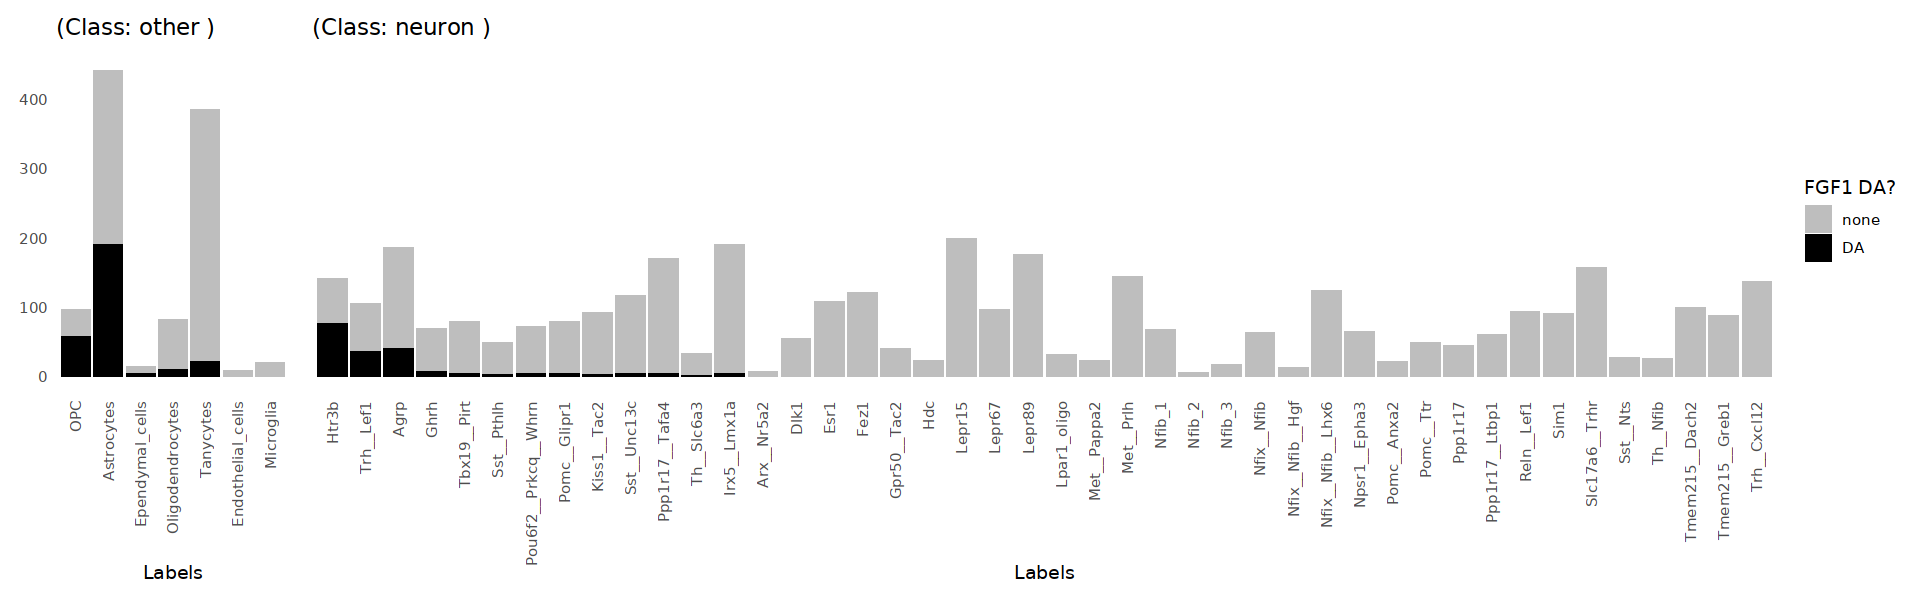

In [9]:
options(repr.plot.width=16, repr.plot.height=5)
# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(data = final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = count, fill = category)) +
      geom_bar(stat = "identity", position = "stack") +
      scale_y_continuous(limits = c(0, 450)) +

      scale_fill_manual(values = c("none" = "gray", "DA" = "black")) +
      theme_minimal() +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Count") +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "FGF1 DA?") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
#   axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

plots[[2]] = plots[[2]] + theme(axis.text.y = element_blank())

# Combine the plots with adjusted widths
nh_count_plot <- wrap_plots(plots, widths = widths) + plot_layout(guides='collect')

# Display the combined plot
# combined_plot %>% ggsave('nh_sum_d5_pct.pdf', plot = ., width = 16, height=5)
nh_count_plot

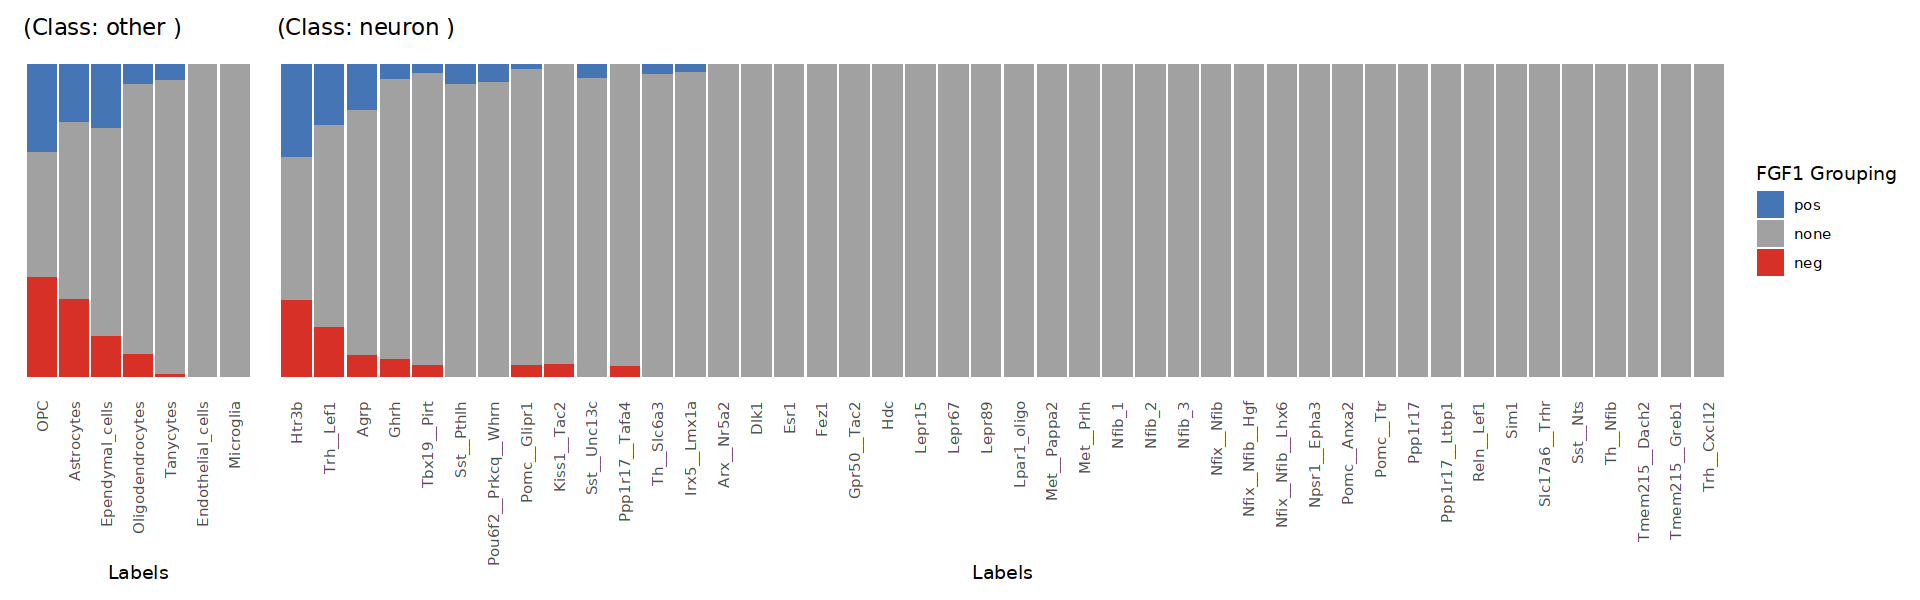

In [10]:
options(repr.plot.width=16, repr.plot.height=5)
# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = fgf1_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
#       geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 3) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#d73027",
                                   'pos' = "#4575b4")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "FGF1 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot %>% ggsave('nh_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot

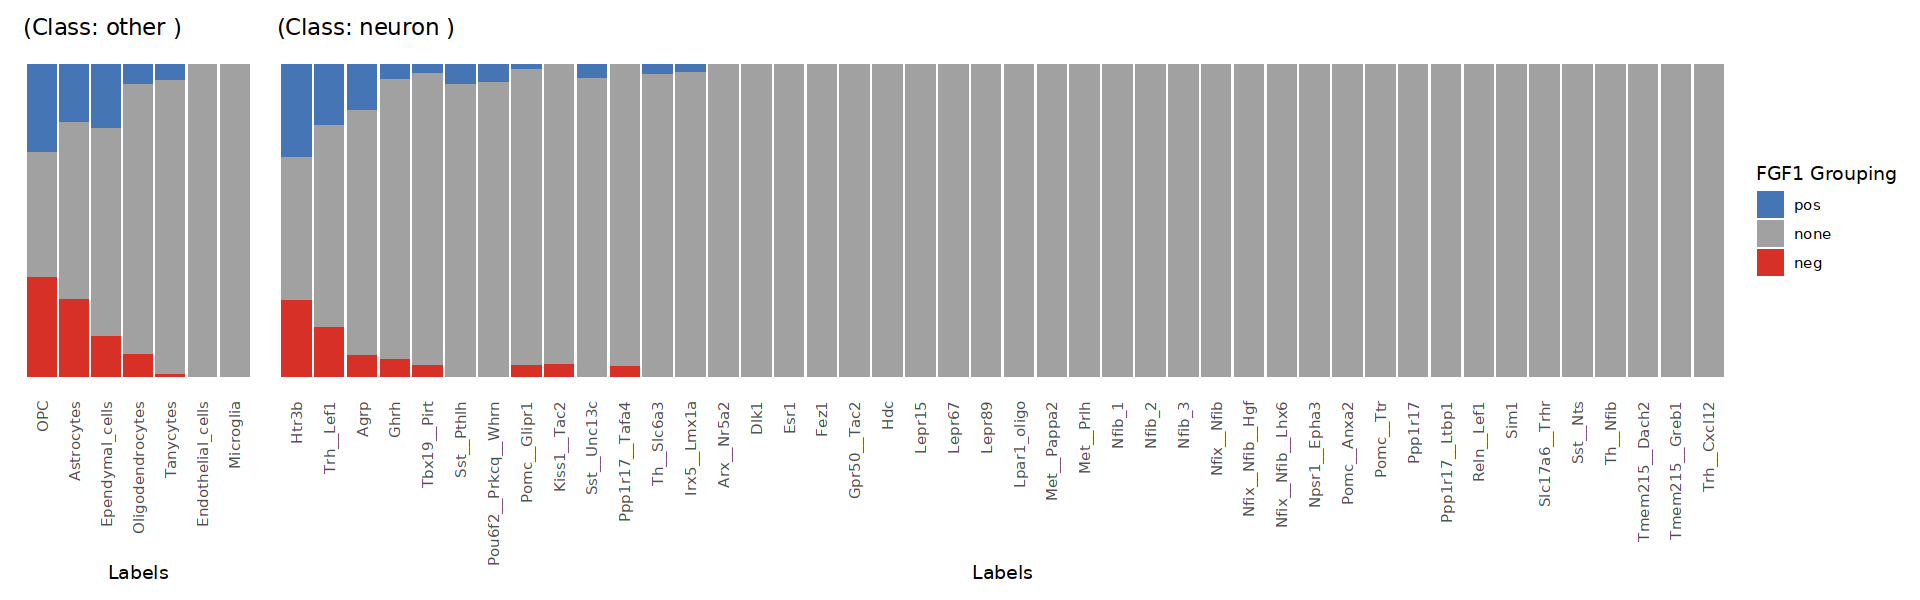

In [11]:

# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = fgf1_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
#       geom_text(aes(label = text_percent), position = position_fill(vjust = 0.5), color = "white", size = 2) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#d73027",
                                   'pos' = "#4575b4")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "FGF1 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")
combined_plot

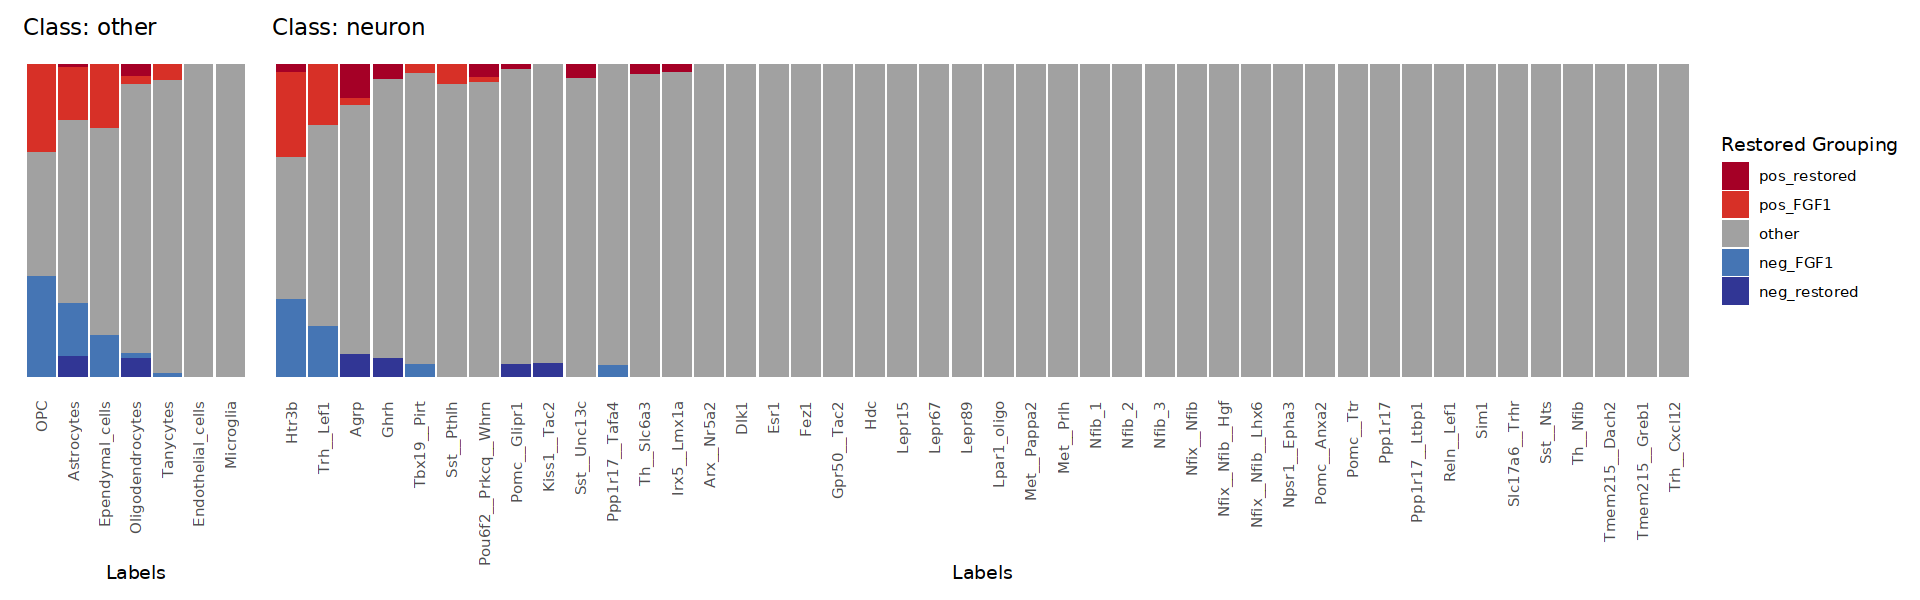

In [12]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
# Step 1: Modify restored_grouping
beeswarm_results <- beeswarm_results %>%
  mutate(restored_grouping = case_when(
    restored_grouping %in% c("pos_restored", "pos_FGF1", "neg_FGF1", "neg_restored") ~ restored_grouping,
    TRUE ~ "other"
  ))


# Step 2: Recalculate summaries and percentages
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, restored_grouping) %>%
  summarise(count = n(), .groups = 'drop')

not_none_summary <- original_summary %>%
  filter(restored_grouping != 'other') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')


# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), desc(total_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))
         
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(not_none_percent = not_none_count/ total_count) %>%
  mutate(restored_grouping = factor(restored_grouping, levels = c("pos_restored", "pos_FGF1", "other", "neg_FGF1", "neg_restored"))) %>%
  arrange(desc(not_none_percent), desc(count), labels)

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels)) %>%
    rowwise %>%
    mutate(text_percent = decimal_to_percent_text(percent)) %>%
    ungroup




# Step 3: Create plots for each class and combine them using patchwork
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = restored_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
#       geom_text(aes(label = text_percent), position = position_fill(vjust = 0.5), color = "white", size = 2, label.size=0) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c(
        'other' =  "#a1a1a1",
        'neg_FGF1' = "#4575b4",
        'pos_FGF1' = "#d73027",
        'neg_restored' = "#313695",
        'pos_restored' = "#a50026"
      )) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
            axis.ticks = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Percentage",
           fill = "Restored Grouping")
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_fgf1 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot_fgf1

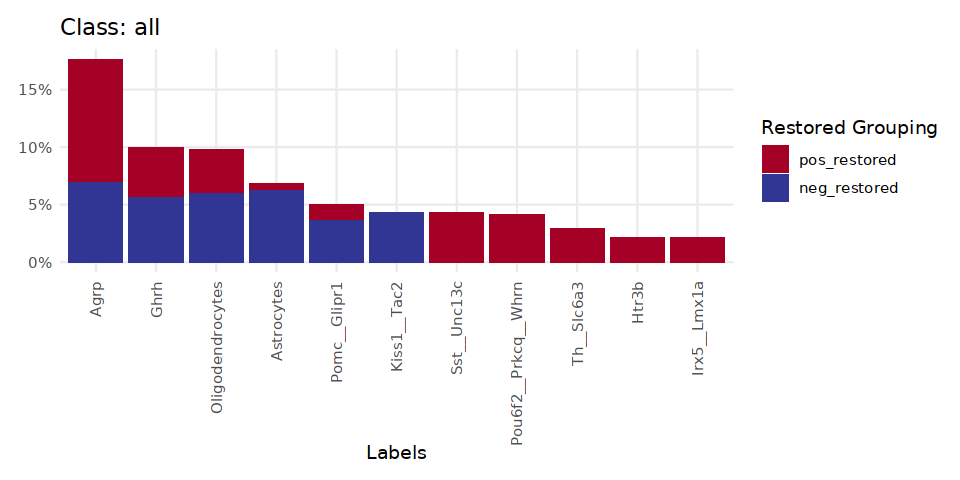

In [37]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
# Step 1: Modify restored_grouping
beeswarm_results <- beeswarm_results %>%
  mutate(restored_grouping = case_when(
    restored_grouping %in% c("pos_restored", "pos_FGF1", "neg_FGF1", "neg_restored") ~ restored_grouping,
    TRUE ~ "other"
  ))


# Step 2: Recalculate summaries and percentages
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, restored_grouping) %>%
  summarise(count = n(), .groups = 'drop')

not_none_summary <- original_summary %>%
  filter(restored_grouping != 'other') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')


# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), desc(total_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))
         
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(not_none_percent = not_none_count/ total_count) %>%
  mutate(restored_grouping = case_when(restored_grouping == 'neg_FGF1' ~ 'other',
                                                restored_grouping == 'pos_FGF1' ~ 'other',
                                                TRUE ~ restored_grouping)) %>%
           filter(restored_grouping != 'other') %>%
  mutate(class = 'all') %>%
  mutate(restored_grouping = factor(restored_grouping, levels = c("pos_restored", "neg_restored"))) %>%
  arrange(desc(not_none_percent), desc(count), labels)

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels)) %>%
    rowwise %>%
    mutate(text_percent = decimal_to_percent_text(percent)) %>%
    ungroup 

#save the level order for this
saved_levels_2 = final_summary_percent %>%
group_by(labels) %>%
summarise(sum_pct = sum(percent)) %>%
arrange(desc(sum_pct)) %>%
pull(labels)

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels_2)) %>%
    arrange(labels)

# Step 3: Create plots for each class and combine them using patchwork
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = restored_grouping)) +
      geom_bar(stat = "identity") +
#       geom_text(aes(label = text_percent), position = position_fill(vjust = 0.5), color = "white", size = 2, label.size=0) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c(
        'other' =  "#a1a1a1",
        'neg_FGF1' = "#4575b4",
        'pos_FGF1' = "#d73027",
        'neg_restored' = "#313695",
        'pos_restored' = "#a50026"
      )) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
            axis.ticks.x = element_blank(),
#             panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
#             axis.text.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Percentage",
           fill = "Restored Grouping")
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_no_fgf1 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
options(repr.plot.width=8, repr.plot.height=4)
combined_plot_no_fgf1

In [38]:
combined_plot_no_fgf1 %>% ggsave('nh_pct_combined_plot_no_fgf1.pdf', plot = ., width = 8, height=4)

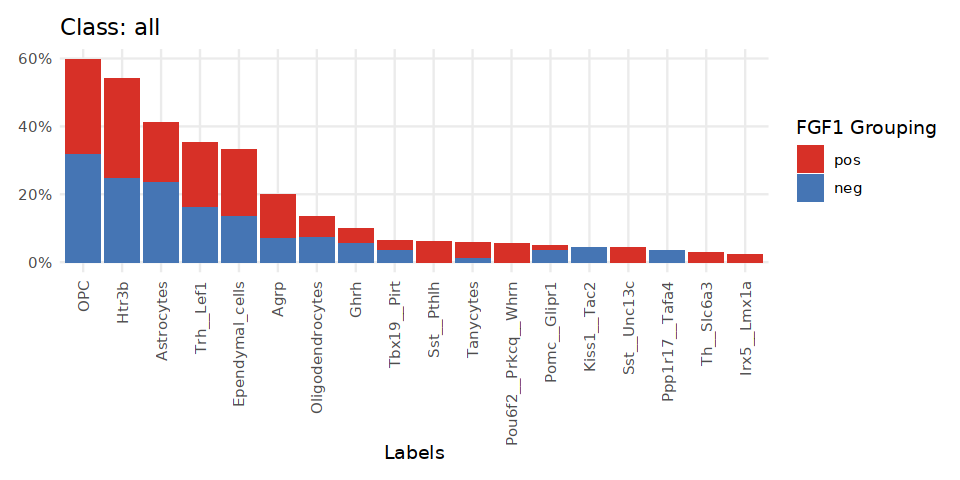

In [42]:
beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
# Step 1: Modify restored_grouping
beeswarm_results <- beeswarm_results %>%
  mutate(restored_grouping = case_when(
    restored_grouping %in% c("pos_restored", "pos_FGF1", "neg_FGF1", "neg_restored") ~ restored_grouping,
    TRUE ~ "other"
  ))


# Step 2: Recalculate summaries and percentages
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, restored_grouping) %>%
  summarise(count = n(), .groups = 'drop')

not_none_summary <- original_summary %>%
  filter(restored_grouping != 'other') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')


# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), desc(total_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))
         
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(not_none_percent = not_none_count/ total_count) %>%
  mutate(restored_grouping = case_when(restored_grouping == 'neg_restored' ~ 'neg',
                                       restored_grouping == 'pos_restored' ~ 'pos',
                                       restored_grouping == 'pos_FGF1' ~ 'pos',
                                       restored_grouping == 'neg_FGF1' ~ 'neg',
                                       TRUE ~ restored_grouping)) %>%
           filter(restored_grouping != 'other') %>%
  mutate(class = 'all') %>%
  mutate(restored_grouping = factor(restored_grouping, levels = c("pos", "neg"))) %>%
  arrange(desc(not_none_percent), desc(count), labels)

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels)) %>%
    rowwise %>%
    mutate(text_percent = decimal_to_percent_text(percent)) %>%
    ungroup 

#save the level order for this
saved_levels_2 = final_summary_percent %>%
group_by(labels) %>%
summarise(sum_pct = sum(percent)) %>%
arrange(desc(sum_pct)) %>%
pull(labels)

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels_2)) %>%
    arrange(labels)

# Step 3: Create plots for each class and combine them using patchwork
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = restored_grouping)) +
      geom_bar(stat = "identity") +
#       geom_text(aes(label = text_percent), position = position_fill(vjust = 0.5), color = "white", size = 2, label.size=0) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c(
        'other' =  "#a1a1a1",
        'neg' = "#4575b4",
        'pos' = "#d73027",
        'neg_restored' = "#313695",
        'pos_restored' = "#a50026"
      )) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
            axis.ticks.x = element_blank(),
#             panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
#             axis.text.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Percentage",
           fill = "FGF1 Grouping")
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_only_fgf1 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
options(repr.plot.width=8, repr.plot.height=4)
combined_plot_only_fgf1

In [43]:
combined_plot_only_fgf1 %>% ggsave('nh_pct_combined_plot_no_restored.pdf', plot = ., width = 8, height=4)

In [15]:
final_summary_percent %>%
group_by(labels) %>%
summarise(sum_pct = sum(percent)) %>%
arrange(desc(sum_pct)) %>%
pull(labels)

[1] Agrp                Ghrh                Oligodendrocytes   
 [4] Astrocytes          Pomc__Glipr1        Kiss1__Tac2        
 [7] Sst__Unc13c         Pou6f2__Prkcq__Whrn Th__Slc6a3         
[10] Htr3b               Irx5__Lmx1a        
11 Levels: Agrp Ghrh Oligodendrocytes Astrocytes Pomc__Glipr1 ... Irx5__Lmx1a

In [16]:
final_summary_percent %>%
group_by(labels) %>%
summarise(sum_pct = sum(percent)) %>%
arrange(desc(sum_pct))

labels,sum_pct
<fct>,<dbl>
Agrp,0.17647059
Ghrh,0.10000000
Oligodendrocytes,0.09756098
Astrocytes,0.06802721
Pomc__Glipr1,0.05000000
Kiss1__Tac2,0.04347826
Sst__Unc13c,0.04273504
Pou6f2__Prkcq__Whrn,0.04109589
Th__Slc6a3,0.02941176


In [17]:
final_summary_percent

class,labels,restored_grouping,count,not_none_count,total_count,percent,not_none_percent,text_percent
<chr>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
all,Agrp,pos_restored,20,37,187,0.106951872,0.19786096,11%
all,Agrp,neg_restored,13,37,187,0.069518717,0.19786096,7%
all,Ghrh,neg_restored,4,7,70,0.057142857,0.10000000,6%
all,Ghrh,pos_restored,3,7,70,0.042857143,0.10000000,4%
all,Oligodendrocytes,neg_restored,5,11,82,0.060975610,0.13414634,6%
all,Oligodendrocytes,pos_restored,3,11,82,0.036585366,0.13414634,4%
all,Astrocytes,neg_restored,28,182,441,0.063492063,0.41269841,6%
all,Astrocytes,pos_restored,2,182,441,0.004535147,0.41269841,<1%
all,Pomc__Glipr1,neg_restored,3,4,80,0.037500000,0.05000000,4%


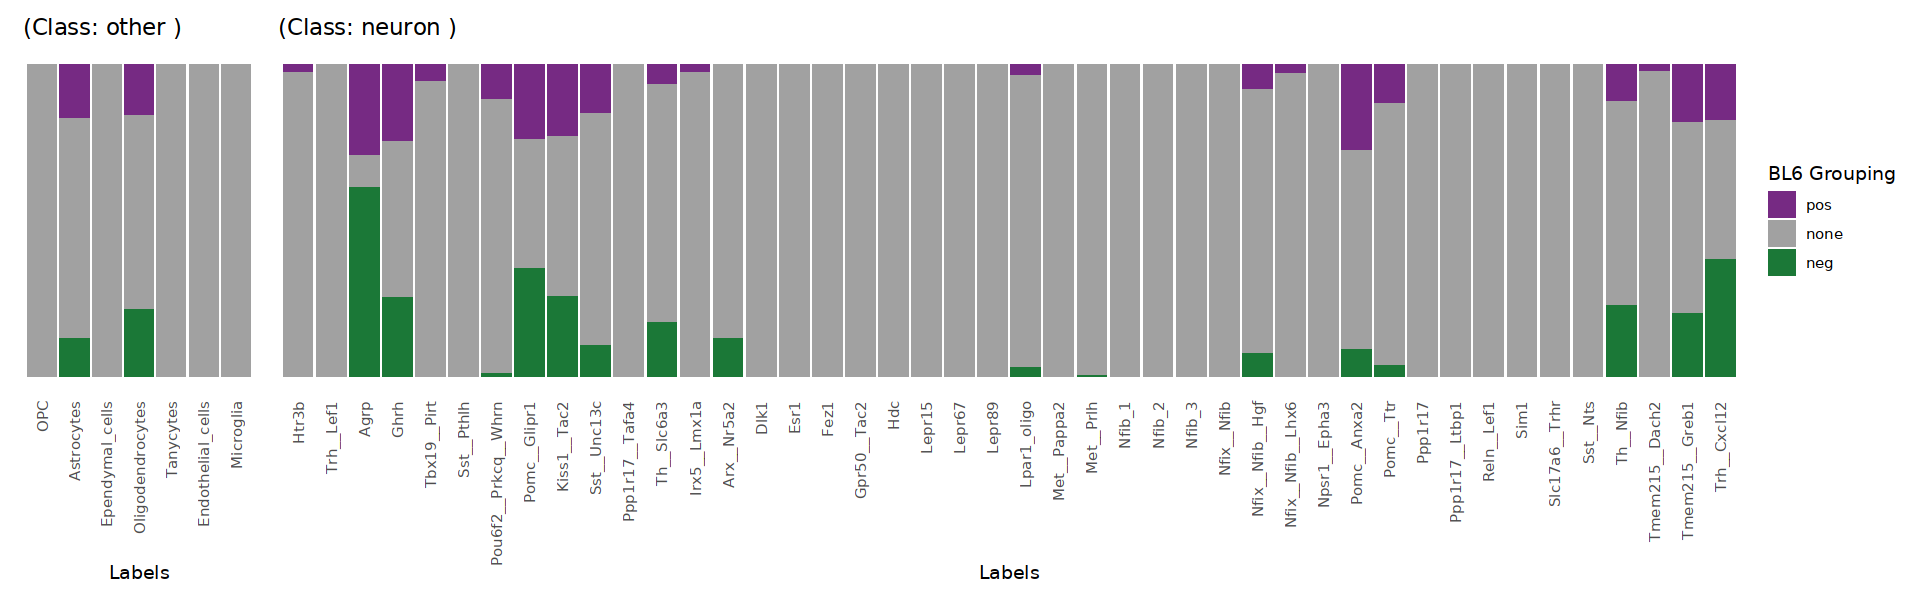

In [18]:
options(repr.plot.width=16, repr.plot.height=5)

beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, polarity_bl6) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(polarity_bl6 != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = saved_levels))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(polarity_bl6 = factor(polarity_bl6, levels = c("pos", "none", "neg"))) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class)) %>%
    rowwise %>%
    mutate(text_percent = decimal_to_percent_text(percent)) %>%
    ungroup


# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = polarity_bl6)) +
      geom_bar(stat = "identity", position = "fill") +
#       geom_text(aes(label = text_percent), position = position_fill(vjust = 0.5), color = "white", size = 2) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#1b7837",
                                   'pos' = "#762a83")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "BL6 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_bl6 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect") +
  plot_layout(guides = 'collect')

# Display the combined plot
# combined_plot %>% ggsave('nh_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot_bl6

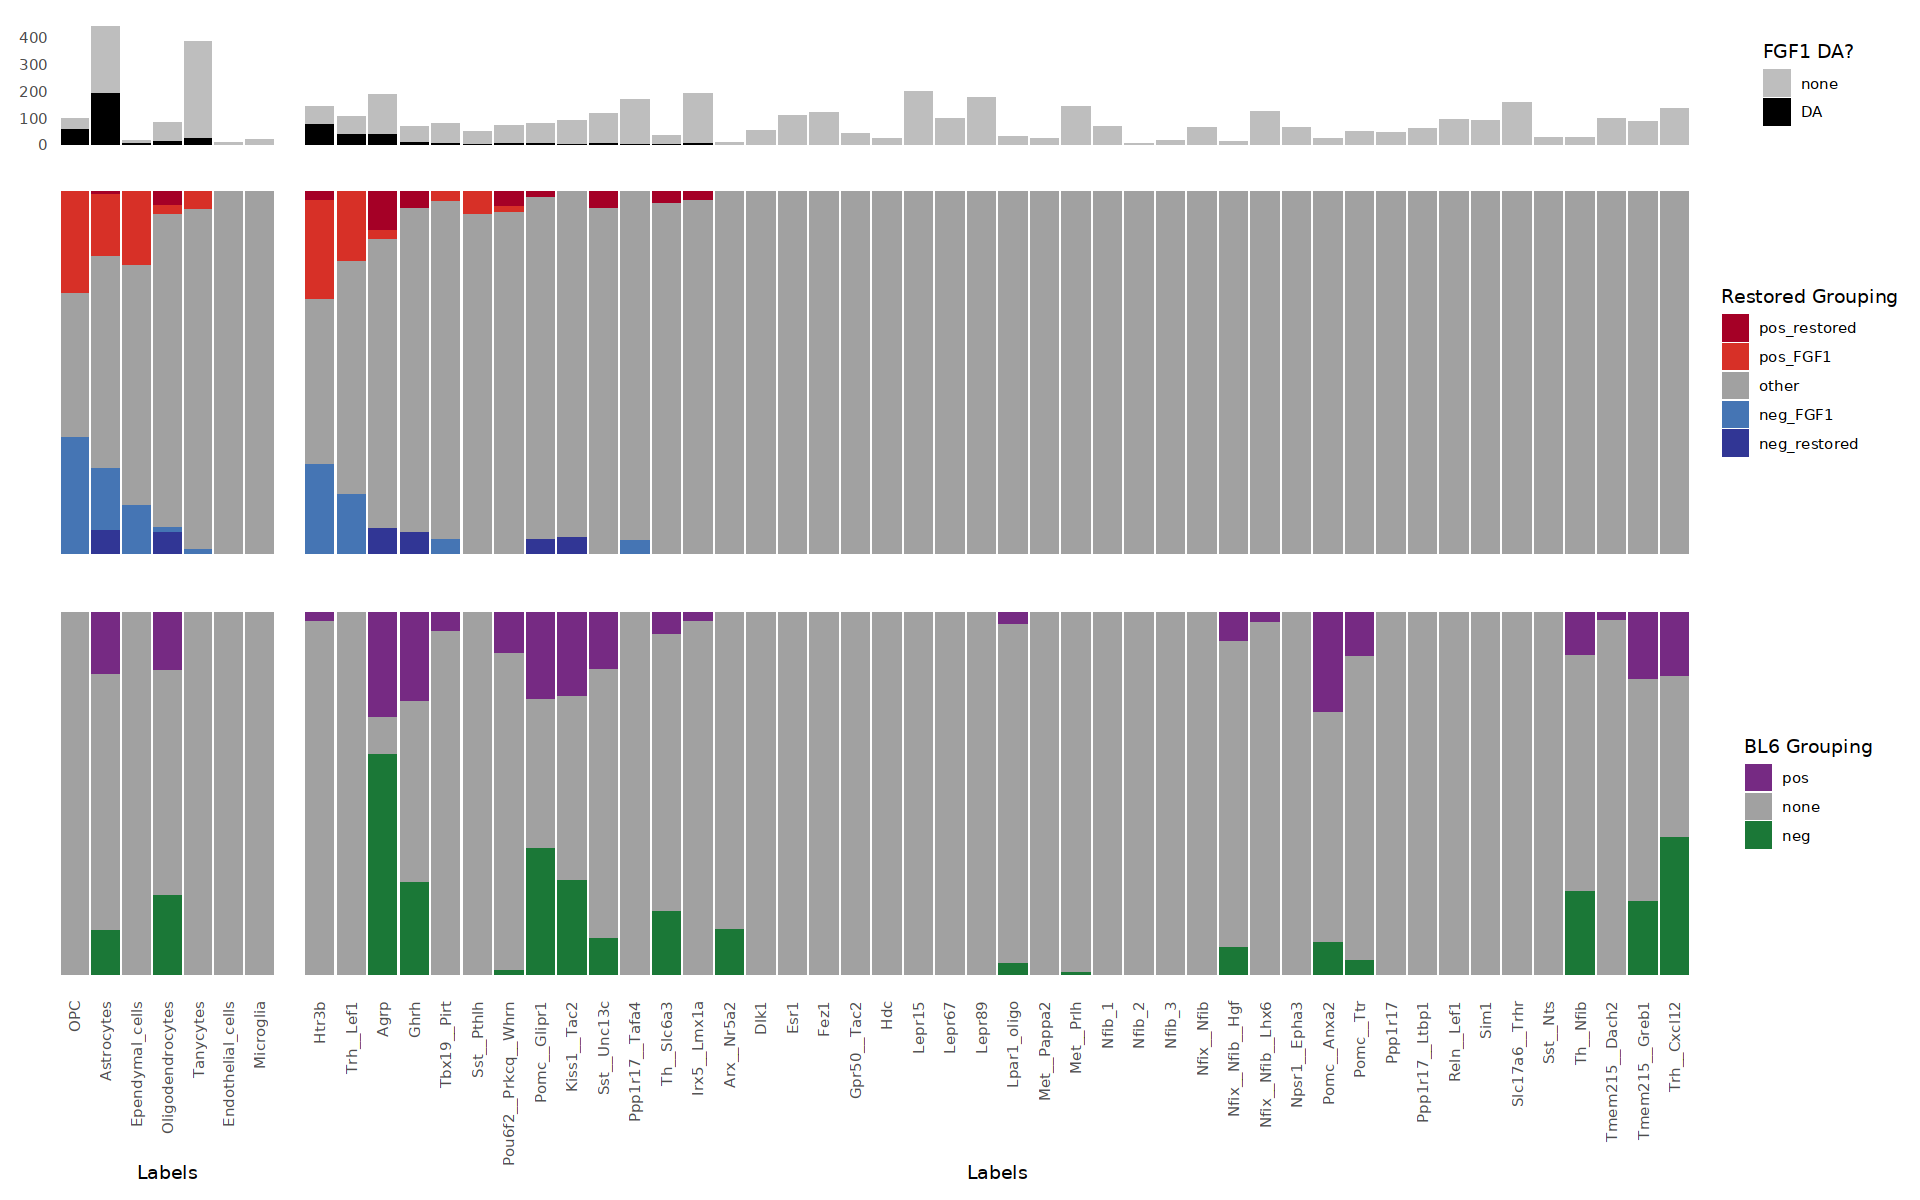

In [19]:
options(repr.plot.width=16, repr.plot.height=10)
combined_plots = (nh_count_plot /
    combined_plot_fgf1 & 
  theme(plot.title = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))

layout <- "
A
B
B
B
C
C
C
"

combined_plots = combined_plots + plot_layout(design=layout, guides = 'collect')
combined_plots

In [20]:
combined_plots %>% ggsave('nh_sum_d5_MAST_restored_pct_count.pdf', plot = ., width = 16, height=10)

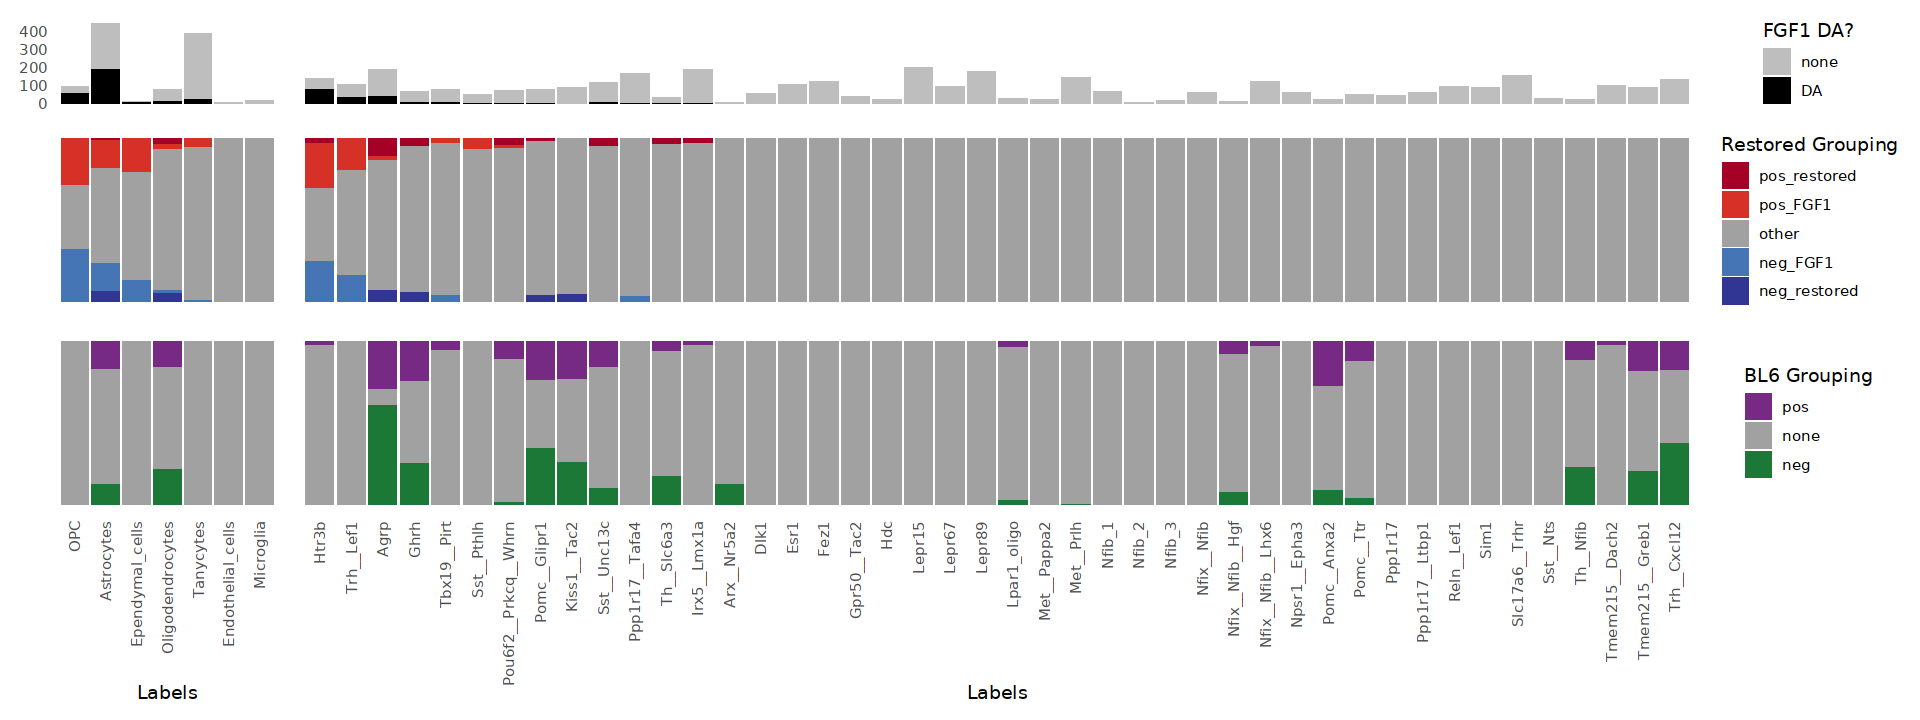

In [25]:
options(repr.plot.width=16, repr.plot.height=6)
combined_plots = (nh_count_plot /
    combined_plot_fgf1 & 
  theme(plot.title = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))

layout <- "
A
B
B
C
C
"

combined_plots = combined_plots + plot_layout(design=layout, guides = 'collect')
combined_plots

In [26]:
combined_plots %>% ggsave('nh_sum_d5_MAST_pct_count.pdf', plot = ., width = 16, height=6)

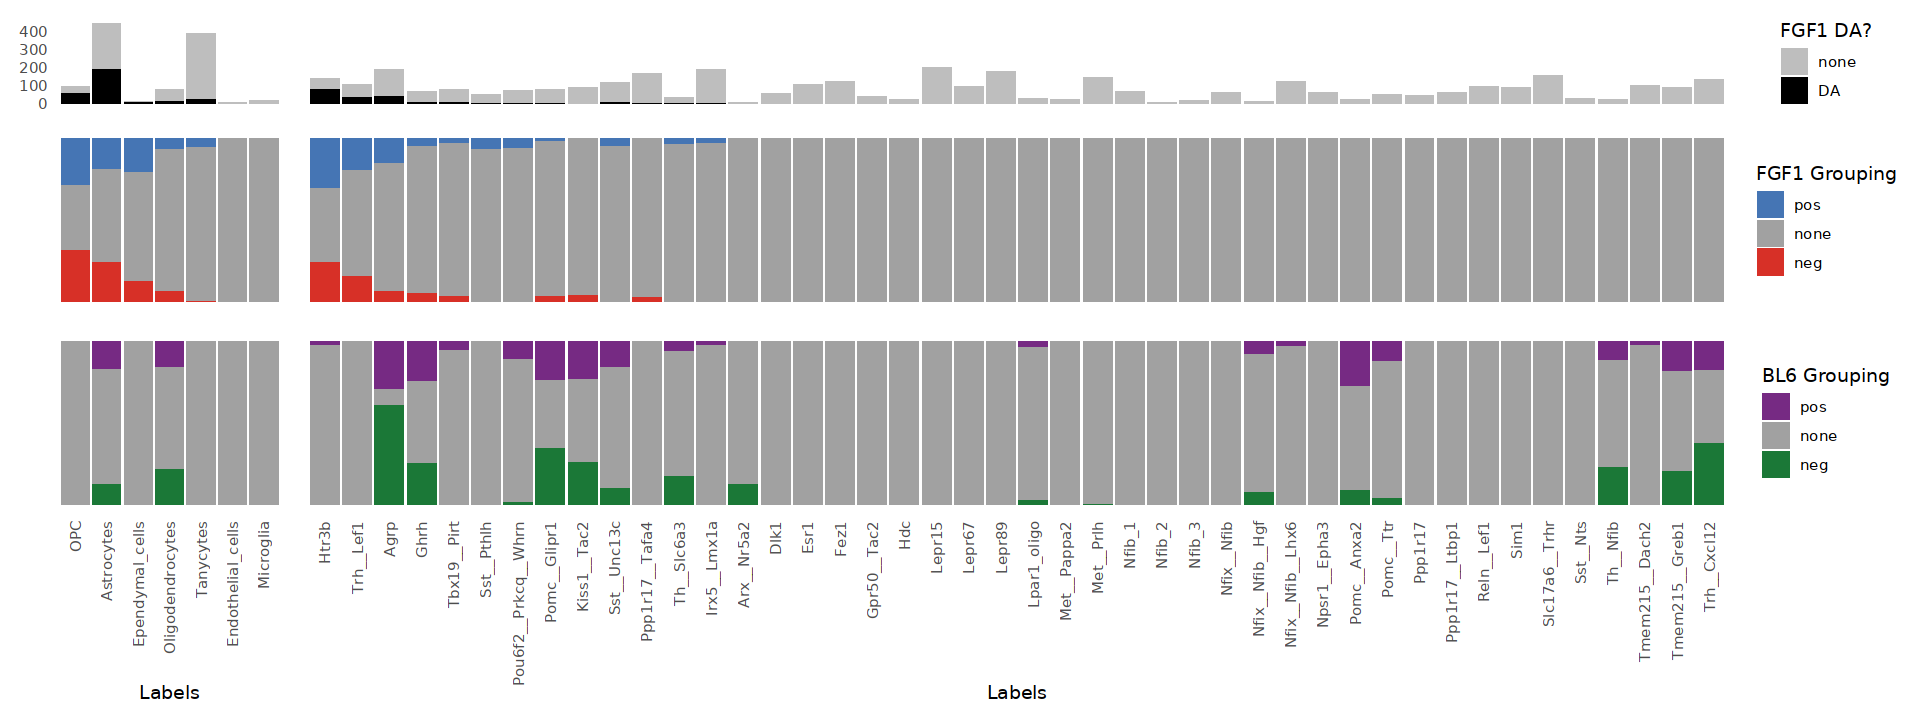

In [27]:
options(repr.plot.width=16, repr.plot.height=6)
combined_plots = (nh_count_plot /
    combined_plot & 
  theme(plot.title = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))

layout <- "
A
B
B
C
C
"

combined_plots = combined_plots + plot_layout(design=layout, guides = 'collect')
combined_plots

In [28]:
combined_plots %>% ggsave('nh_sum_d5_MAST_pct_fgf1.pdf', plot = ., width = 16, height=6)